In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sq3
import bagpipes as pipes
import UCSC_spec_db_interaction as UCSC_db
import h5py

Bagpipes: Latex distribution not found, plots may look strange.


In [3]:
def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = int(len(spectrum)/binn)
    binspec = np.zeros((nbins, spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec


def load_kpora_spec(ID):
    """ Loads kaepora spectroscopic data """
    kpora_spec = kpora_dict[ID]
    wavelength = kpora_spec.wavelength
    flux = kpora_spec.flux*10e-15
    err = kpora_spec.err*10e-15

    mask = (wavelength > 3500.) & (wavelength < 8000.)
    spectrum = np.c_[wavelength[mask],
                     flux[mask],
                     err[mask]]

    return bin(spectrum, 1)

2018jh_1-combined-20180611_ap3_1.5_kpc.fits
1 Total Spectra found


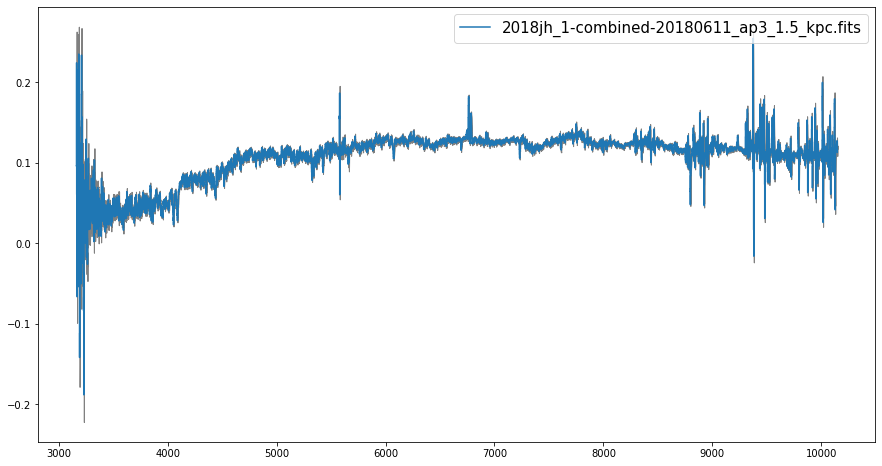

In [5]:
test_query = "SELECT * from SPECTRA where OBJECT like '%18jh%' and FILENAME like '%combined%' and AP_UNIT = 'kpc' and AP_SIZE = 1.5 and filename not like '%_SN%'"
spectra = UCSC_db.query_and_plot(test_query)

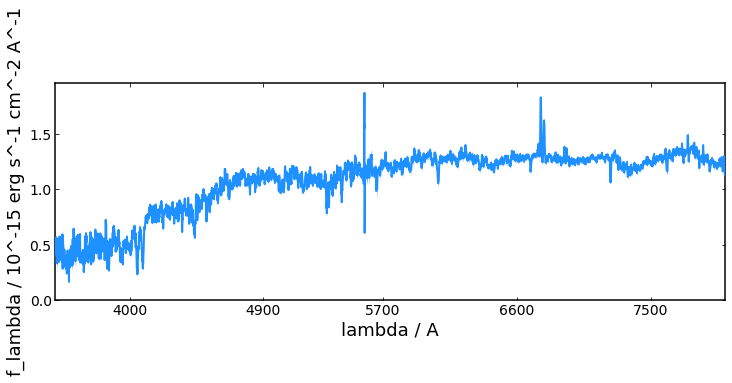

In [6]:
global kpora_dict
kpora_dict = {}
for i, kpora_spec in enumerate(spectra):
    kpora_dict[str(i)] = kpora_spec
for k in kpora_dict.keys():
    ID_number = k
    galaxy = pipes.galaxy(ID_number, load_kpora_spec, photometry_exists=False)

    fig = galaxy.plot()

In [7]:
dblplaw = {}                        
dblplaw["tau"] = (0., 15.)            
dblplaw["alpha"] = (0.01, 1000.)
dblplaw["beta"] = (0.01, 1000.)
dblplaw["alpha_prior"] = "log_10"
dblplaw["beta_prior"] = "log_10"
dblplaw["massformed"] = (1., 15.)
dblplaw["metallicity"] = (0.1, 2.)
dblplaw["metallicity_prior"] = "log_10"

nebular = {}
nebular["logU"] = -3.

dust = {}
dust["type"] = "CF00"
dust["eta"] = 2.
dust["Av"] = (0., 0.5)
dust["n"] = (0.3, 2.5)
dust["n_prior"] = "Gaussian"
dust["n_prior_mu"] = 0.7
dust["n_prior_sigma"] = 0.3

fit_instructions = {}
fit_instructions["redshift"] = (0.01, 0.05)
fit_instructions["t_bc"] = 0.01
fit_instructions["redshift_prior"] = "Gaussian"
fit_instructions["redshift_prior_mu"] = 0.03
fit_instructions["redshift_prior_sigma"] = 0.005
fit_instructions["dblplaw"] = dblplaw 
fit_instructions["nebular"] = nebular
fit_instructions["dust"] = dust

In [8]:
fit_instructions["veldisp"] = (1., 1000.)   #km/s
fit_instructions["veldisp_prior"] = "log_10"

In [9]:
calib = {}
calib["type"] = "polynomial_bayesian"

calib["0"] = (0.5, 1.5) # Zero order is centred on 1, at which point there is no change to the spectrum.
calib["0_prior"] = "Gaussian"
calib["0_prior_mu"] = 1.0
calib["0_prior_sigma"] = 0.25

calib["1"] = (-0.5, 0.5) # Subsequent orders are centred on zero.
calib["1_prior"] = "Gaussian"
calib["1_prior_mu"] = 0.
calib["1_prior_sigma"] = 0.25

calib["2"] = (-0.5, 0.5)
calib["2_prior"] = "Gaussian"
calib["2_prior_mu"] = 0.
calib["2_prior_sigma"] = 0.25

fit_instructions["calib"] = calib

In [10]:
#not used
mlpoly = {}
mlpoly["type"] = "polynomial_max_like"
mlpoly["order"] = 2

In [11]:
noise = {}
noise["type"] = "white_scaled"
noise["scaling"] = (1., 10.)
noise["scaling_prior"] = "log_10"
fit_instructions["noise"] = noise

In [13]:
fit = pipes.fit(galaxy, fit_instructions, run="spectroscopy")
# fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)


Bagpipes: fitting object 0


Completed in 3294.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
calib:0                        1.028      1.032      1.035
calib:1                       -0.290     -0.289     -0.287
calib:2                        0.065      0.066      0.066
dblplaw:alpha                101.377    101.799    102.164
dblplaw:beta                   0.011      0.011      0.012
dblplaw:massformed            10.210     10.211     10.213
dblplaw:metallicity            1.989      1.993      1.997
dblplaw:tau                   12.660     12.661     12.662
dust:Av                        0.019      0.020      0.021
dust:n                         0.729      0.746      0.762
noise:scaling                  1.958      1.965      1.972
redshift                       0.030      0.030      0.030
veldisp                      137.029    137.674    138.39

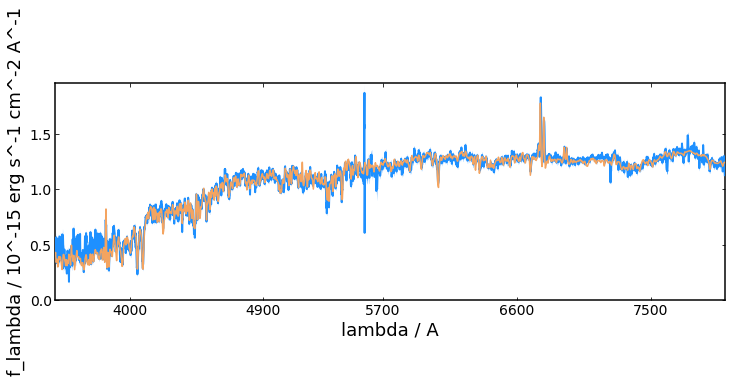

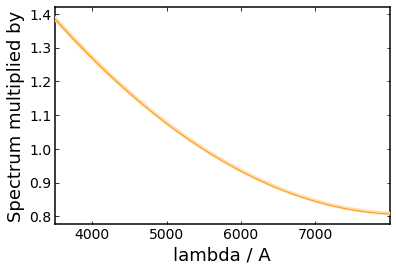

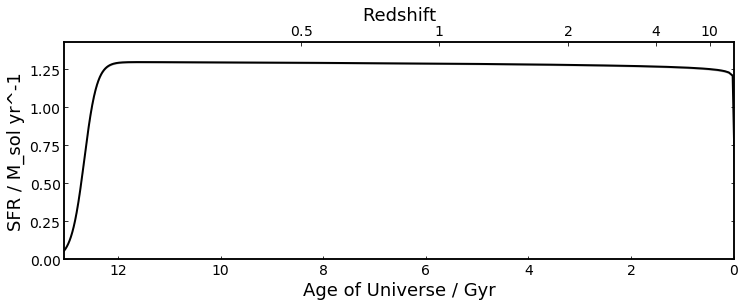

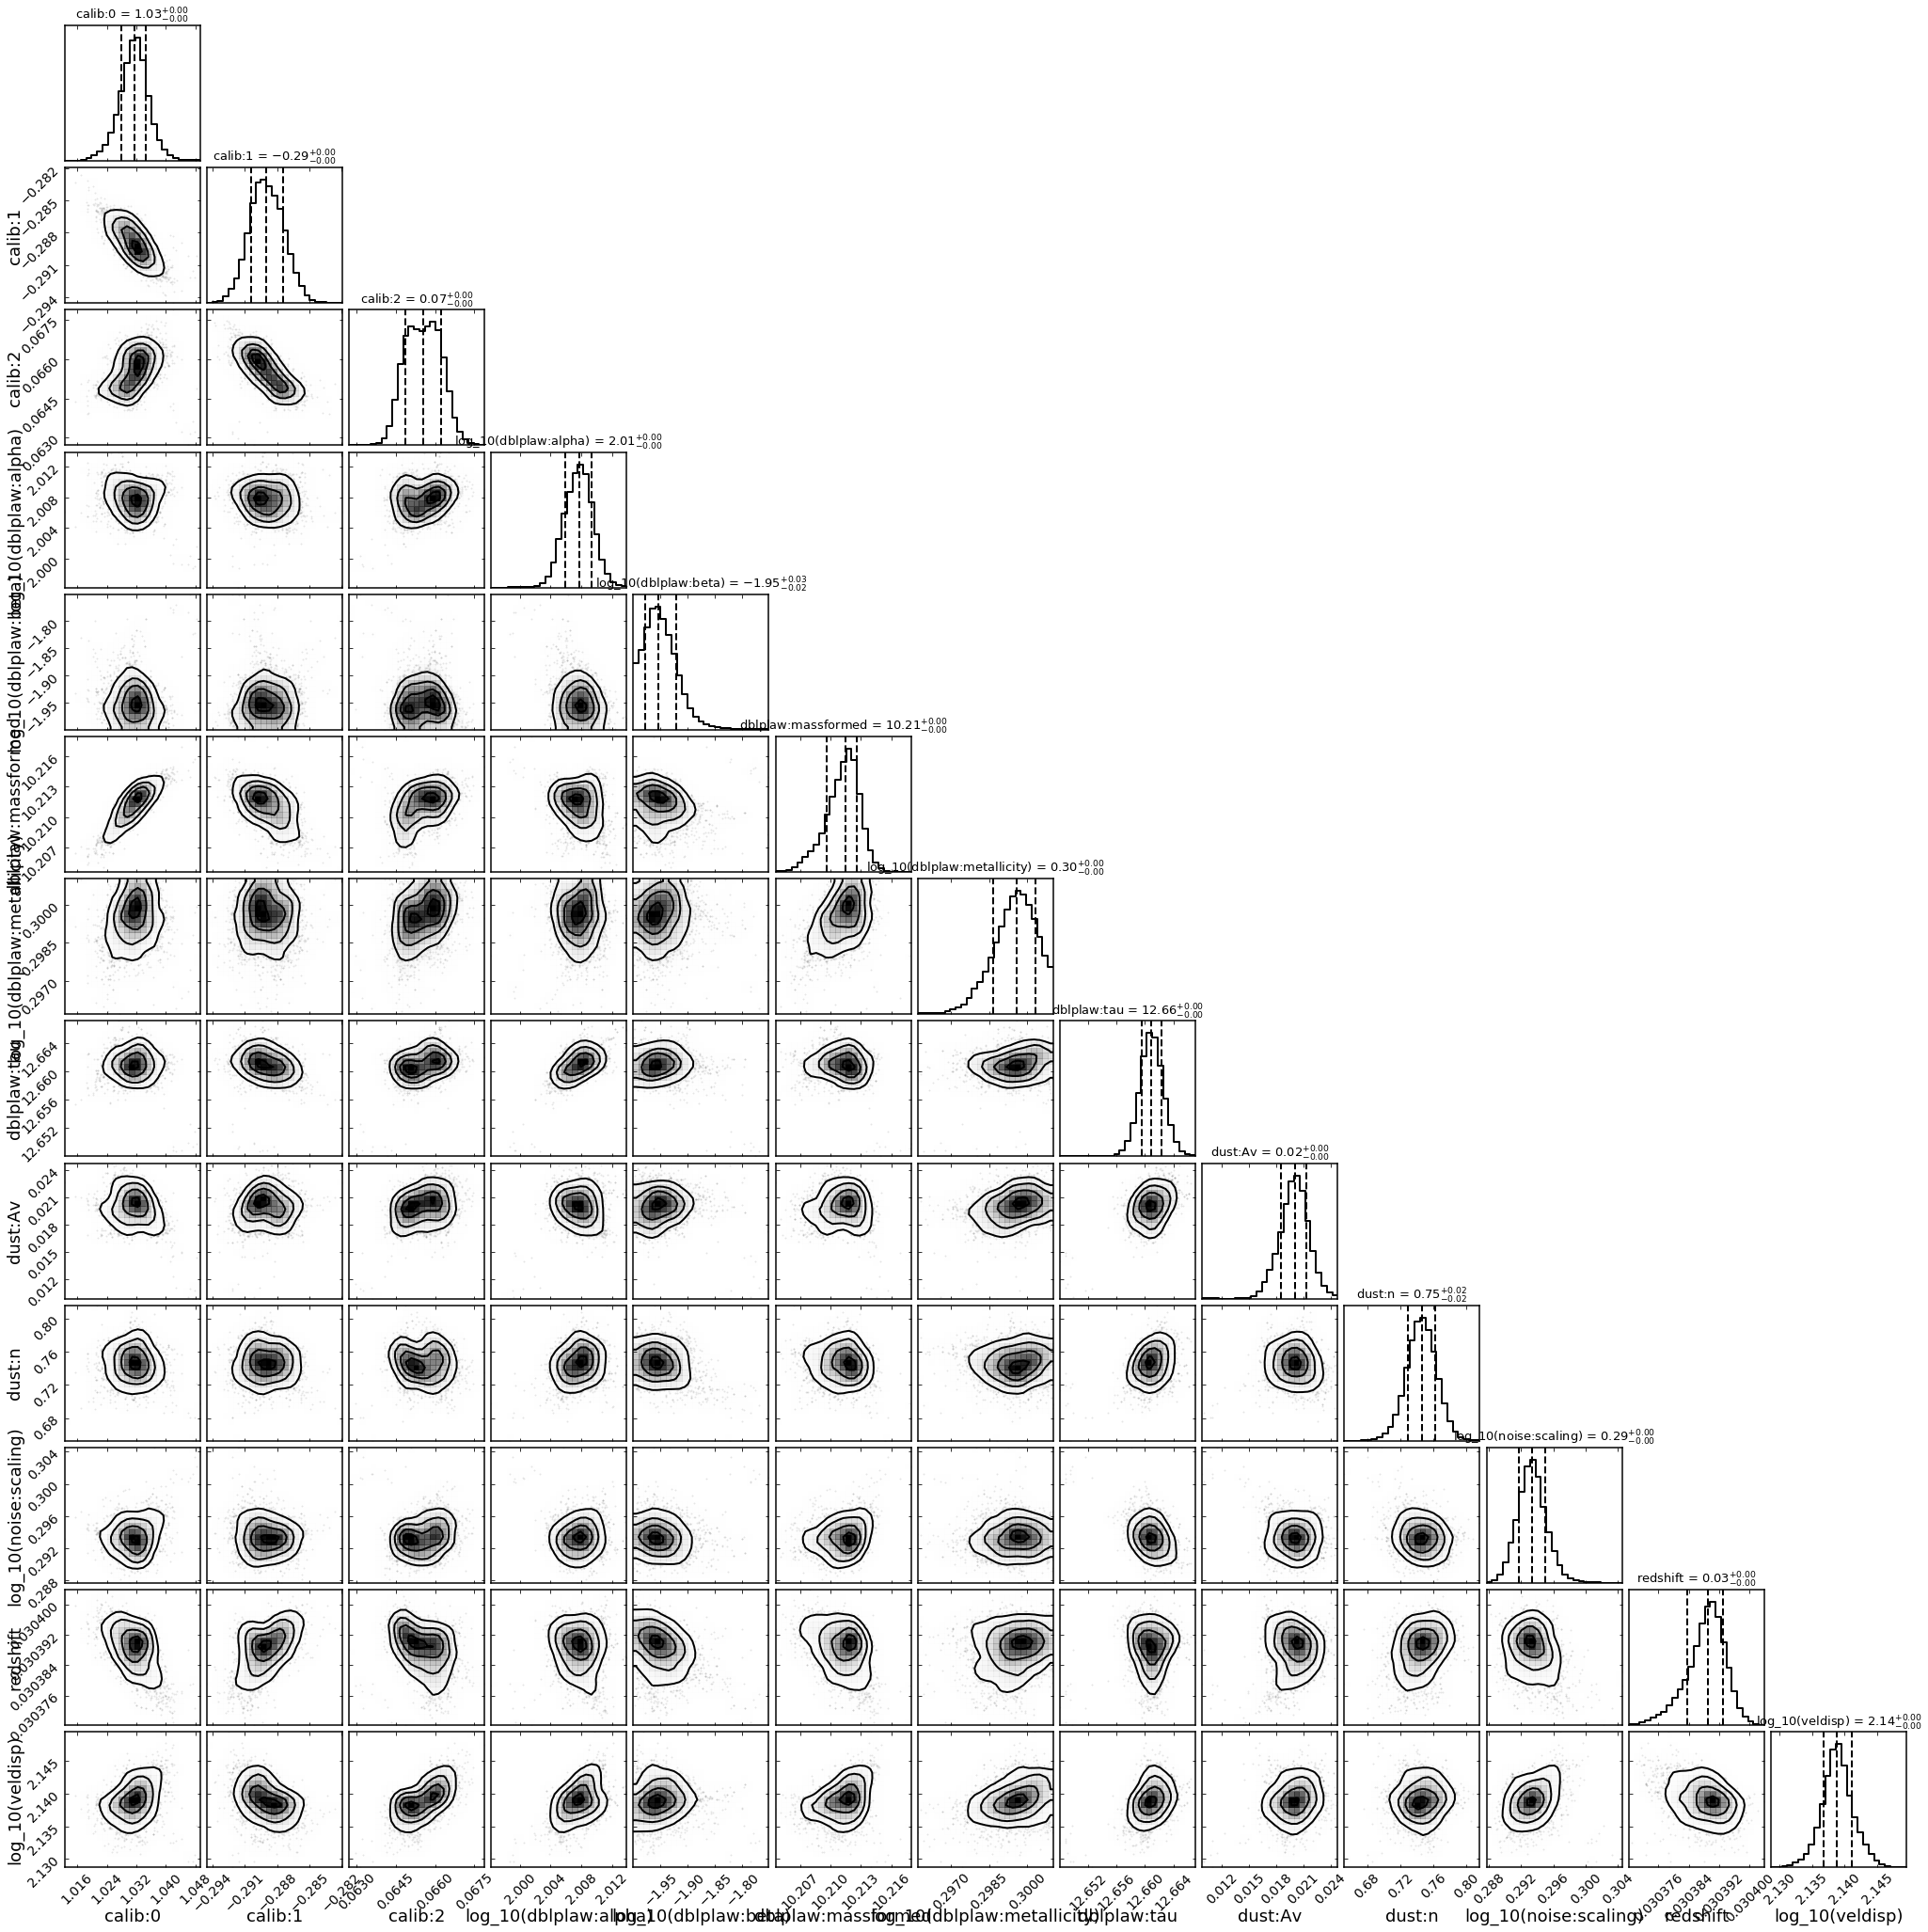

In [14]:
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_calibration(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)

In [15]:
spec_post = np.copy(fit.posterior.samples["spectrum"])

In [16]:
def plot_fit_section(fit, w1 = 3500, w2 = 4800):
    spec_post = np.copy(fit.posterior.samples["spectrum"])
    wave = fit.galaxy.spectrum[:, 0]
    flux_obs = fit.galaxy.spectrum[:, 1]

    post = np.percentile(spec_post, (16, 50, 84), axis=0).T
    roi = (wave > w1) & (wave < w2)

    plt.figure(figsize = [15,8])
    plt.plot(wave[roi],flux_obs[roi])
    plt.plot(wave[roi], post[:, 1][roi], color="sandybrown", zorder=4, lw=1.5)
    plt.fill_between(wave[roi], post[:, 0][roi], post[:, 2][roi], color="sandybrown", zorder=4, alpha=0.75, linewidth=0)
    # for data in spec_post:
    #     plt.plot(wave[roi],data[roi], color = 'sandybrown', alpha=.2)
    plt.show()

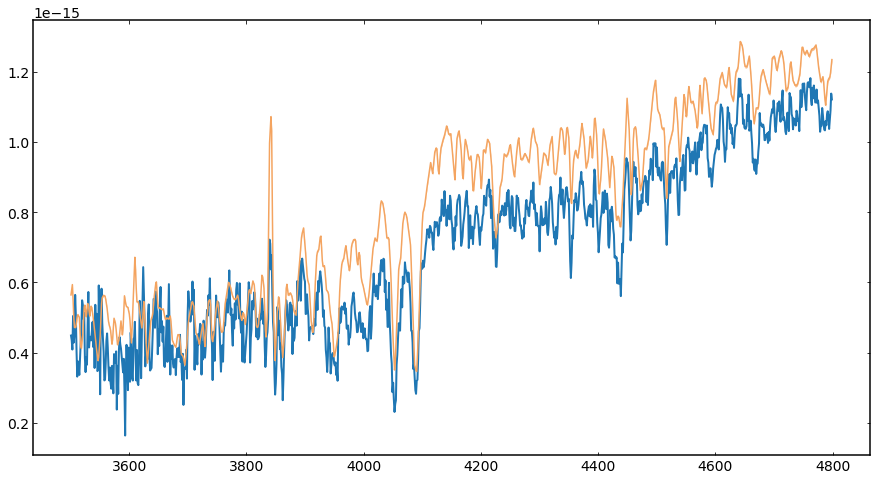

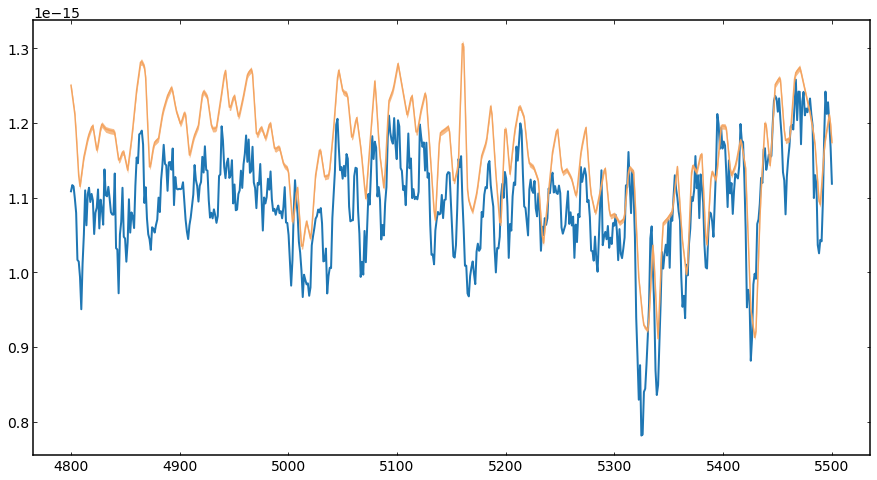

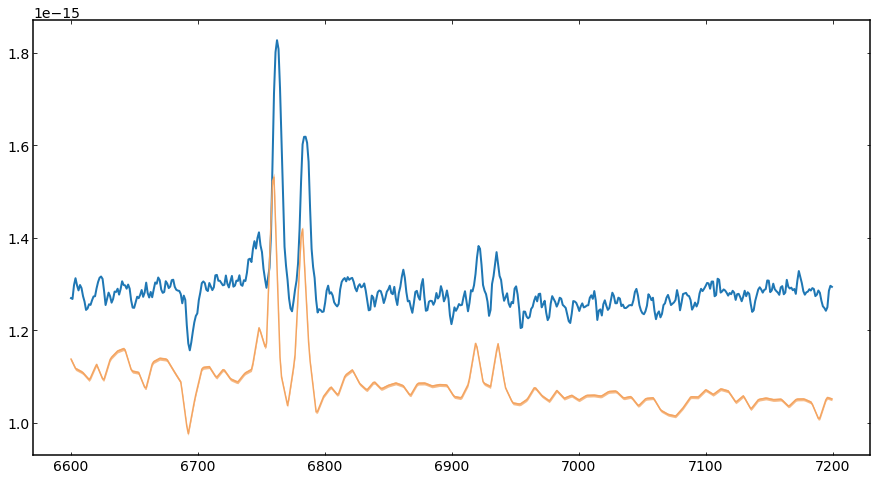

In [17]:
plot_fit_section(fit, w1 = 3500, w2 = 4800)
plot_fit_section(fit, w1 = 4800, w2 = 5500)
plot_fit_section(fit, w1 = 6600, w2 = 7200)

In [18]:
def to_log12(z):
    #Log(O/H) + 12 = Log( 0.35 x 0.0127 / (0.74 * 16) ) + 12 = 8.57 to account for Hydrogen only being ~74% of the total mass.
    # Assume that oxygen is 35% of the metal mass
    oxy_mass_frac = 0.35*z
    n_oxy_frac = oxy_mass_frac/(.74*16.0)
    logOH = np.log10(n_oxy_frac)
    return logOH + 12

In [21]:
print (to_log12(.3))

9.947837596683037


2018jh_1-combined-20180611_ap4_1.5_kpc_SN.fits
1 Total Spectra found


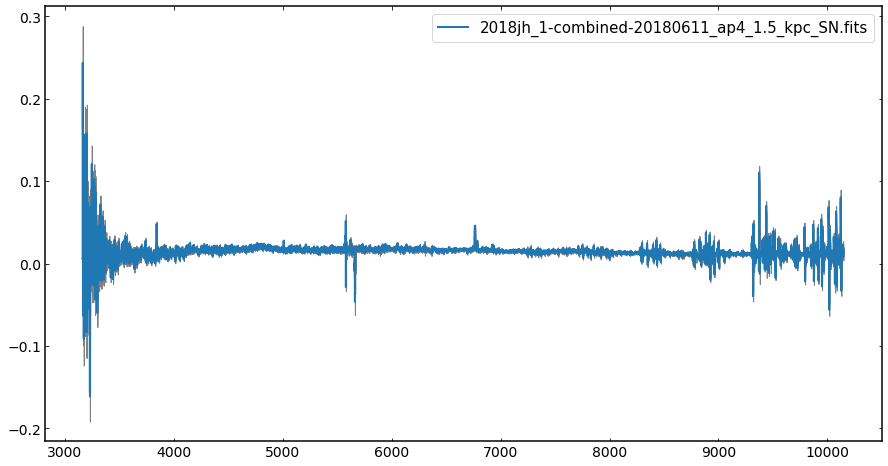

In [22]:
test_query = "SELECT * from SPECTRA where OBJECT like '%18jh%' and FILENAME like '%combined%' and AP_UNIT = 'kpc' and AP_SIZE = 1.5 and filename like '%_SN%'"
spectra = UCSC_db.query_and_plot(test_query)

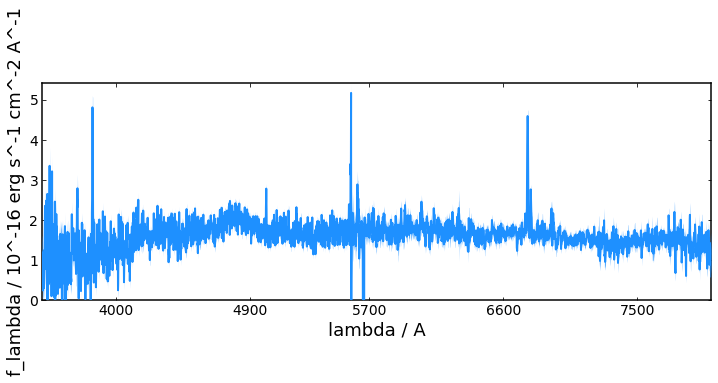

In [23]:
kpora_dict = {}
kpora_dict['1'] = spectra[0]
for k in kpora_dict.keys():
    ID_number = k
    galaxy = pipes.galaxy(ID_number, load_kpora_spec, photometry_exists=False)

    fig = galaxy.plot()

In [24]:
fit = pipes.fit(galaxy, fit_instructions, run="spectroscopy")
# fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)


Bagpipes: fitting object 1


Completed in 11551.5 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
calib:0                        0.940      1.105      1.265
calib:1                        0.046      0.086      0.125
calib:2                       -0.053     -0.041     -0.030
dblplaw:alpha                  1.605      1.895      2.534
dblplaw:beta                   0.025      0.091      0.543
dblplaw:massformed             9.539      9.613      9.678
dblplaw:metallicity            0.100      0.101      0.103
dblplaw:tau                    0.704      1.470      3.289
dust:Av                        0.420      0.465      0.490
dust:n                         0.643      0.823      0.985
noise:scaling                  1.578      1.594      1.610
redshift                       0.031      0.031      0.031
veldisp                      144.667    150.773    157.3

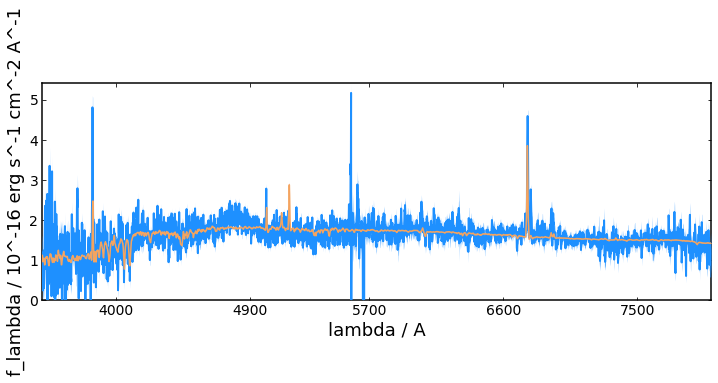

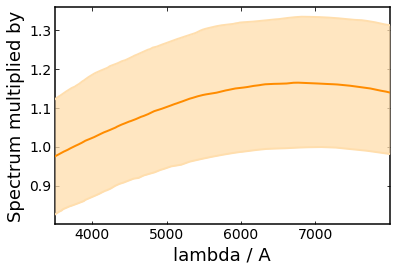

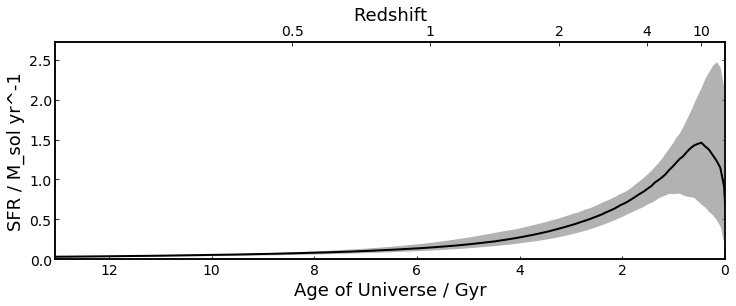

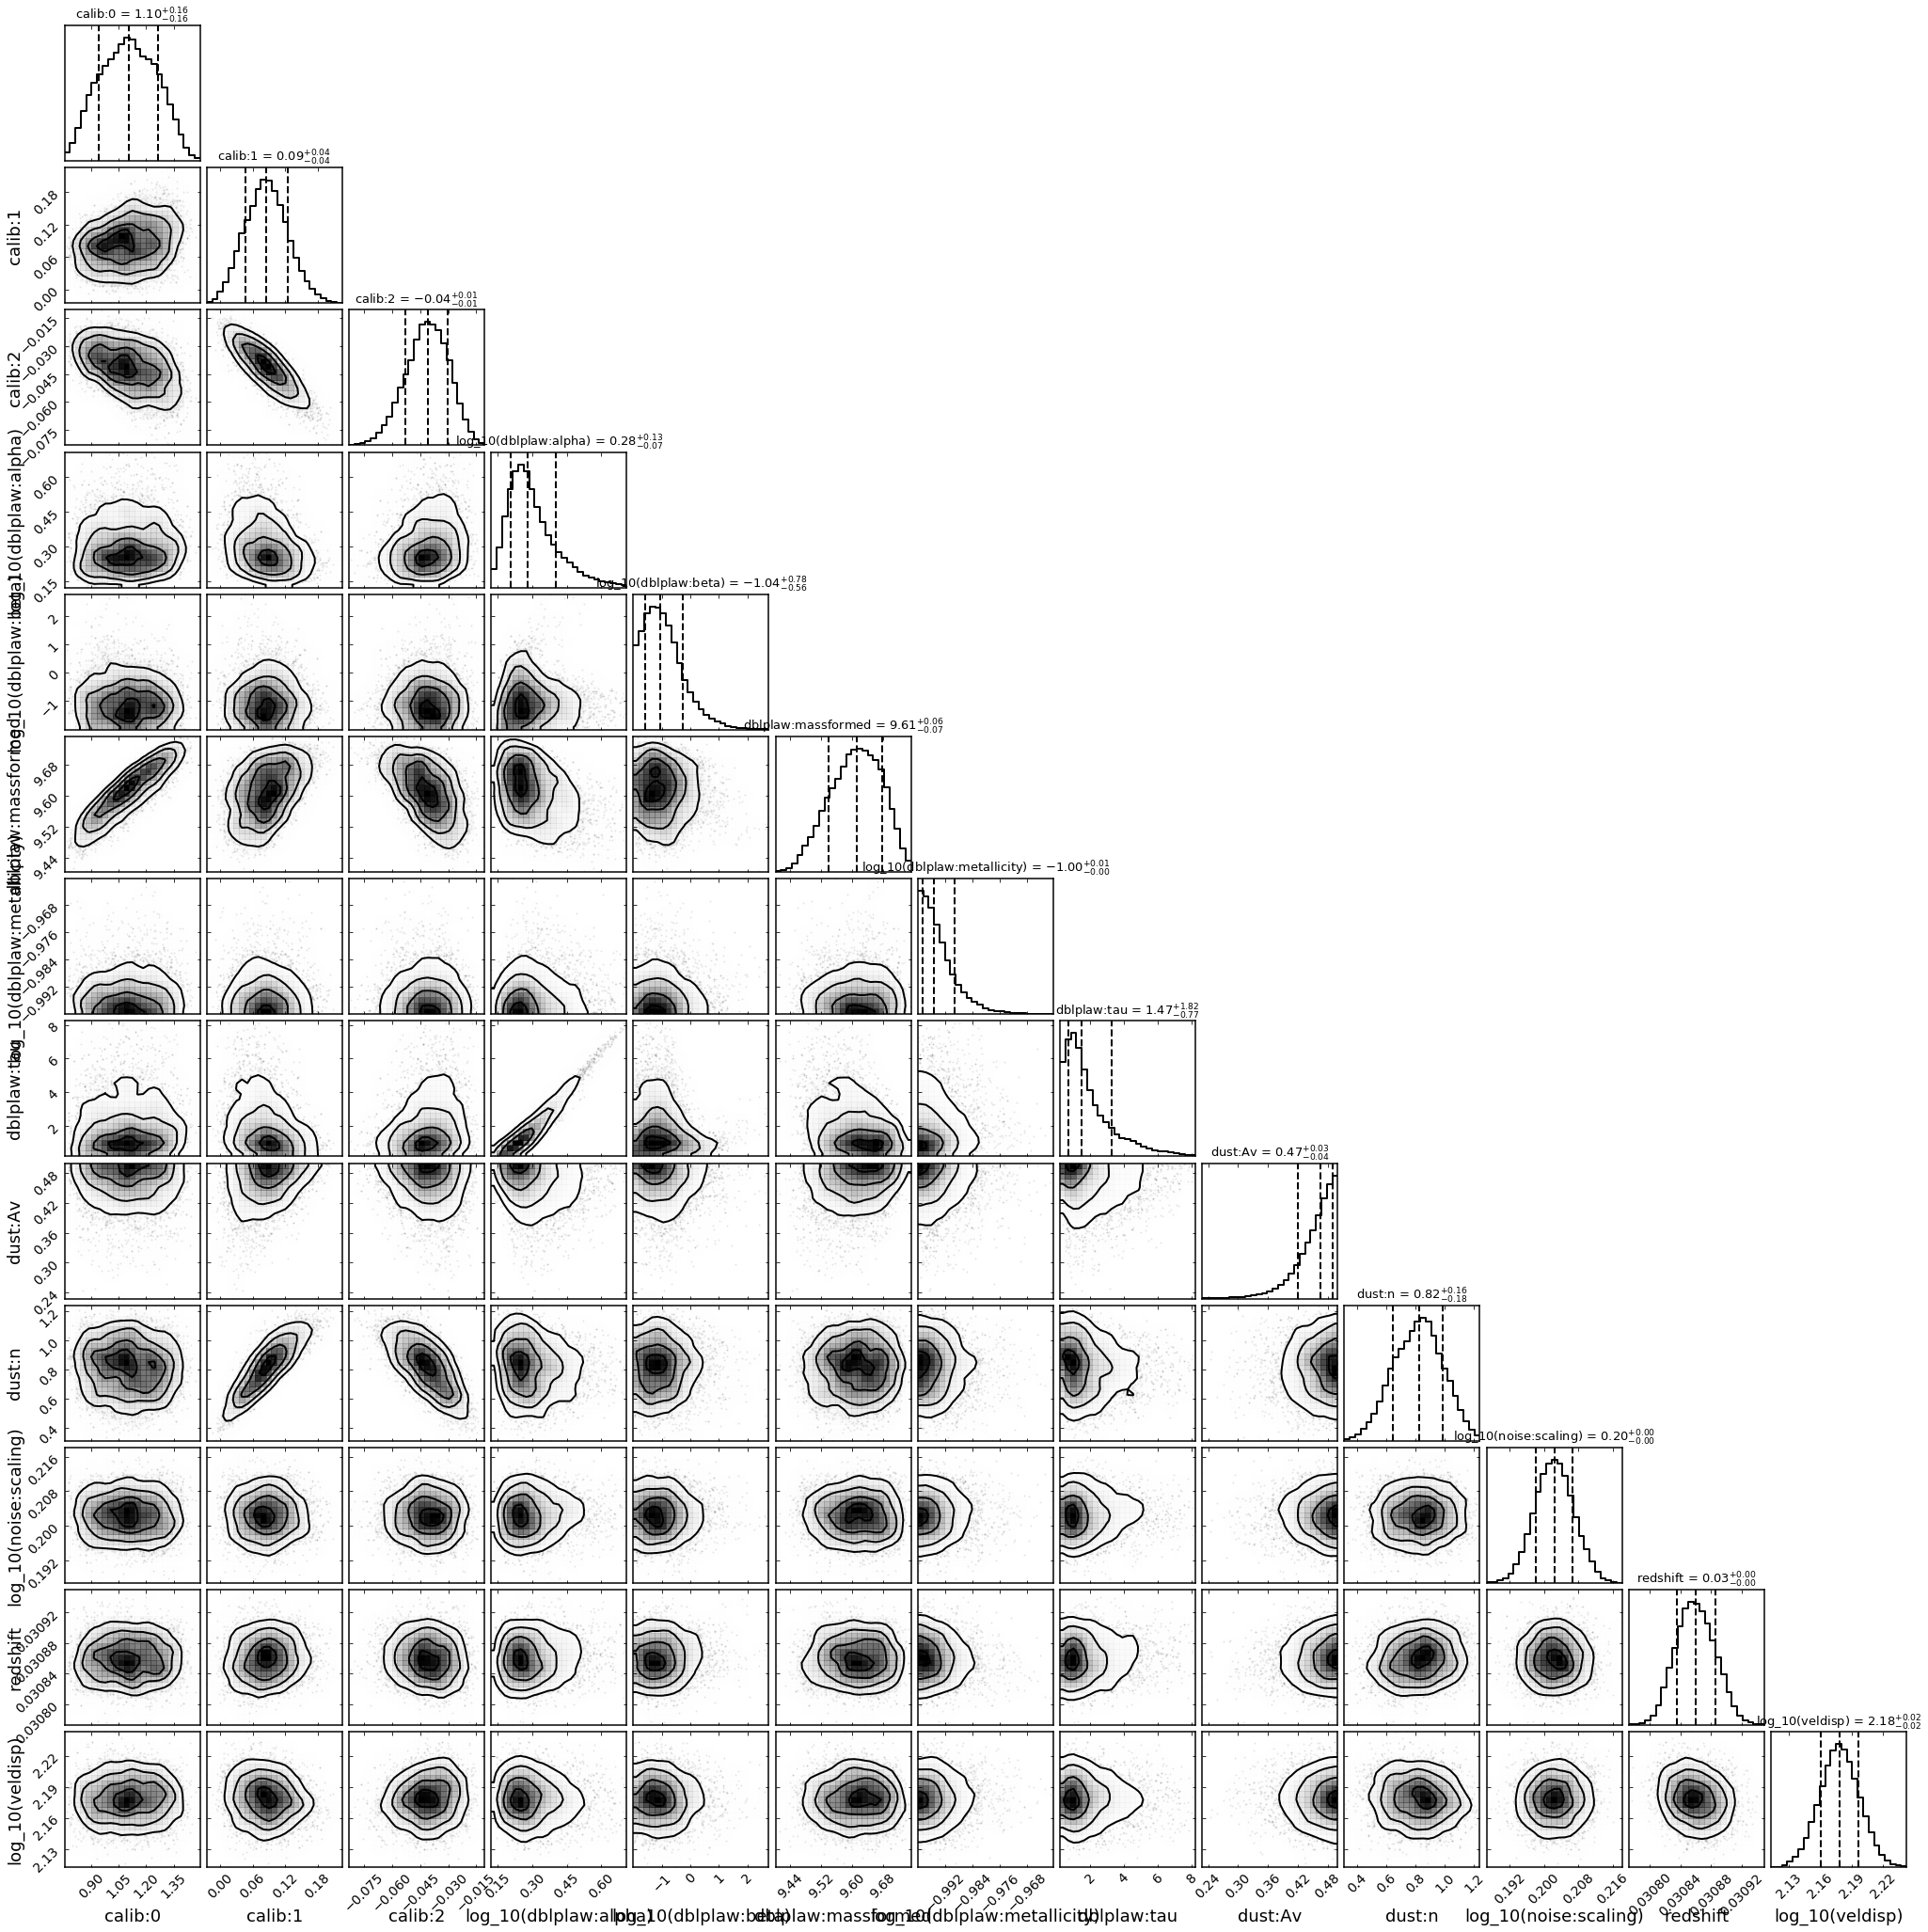

In [25]:
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_calibration(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)